## AGENTIC RAG
1. 2 vector databases - FAISS, ChromaDB <> 2 retrievers
2. 1 Wikipedia Loader, 1 ArxivLoader
3. Rewriter
4. Generator

In [120]:
from langchain_community.document_loaders import WebBaseLoader, DirectoryLoader, TextLoader
from langchain_community.vectorstores import FAISS,Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage,BaseMessage,ToolMessage
from langchain_core.prompts import ChatPromptTemplate,HumanMessagePromptTemplate,SystemMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableMap,RunnableLambda,RunnableParallel,RunnablePassthrough
from typing import List,TypedDict,Literal,Annotated
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END,StateGraph,START
from langchain.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain.tools import WikipediaQueryRun
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel,Field
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch

from dotenv import load_dotenv
load_dotenv()

llm_model = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash',max_retries=2)
embedding_model = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2') ##embedding model

In [8]:
### Retriever Tools ###
docs = DirectoryLoader(
    path='data',
    glob='*.txt',
    loader_cls=TextLoader,
    loader_kwargs={'encoding':'utf-8'}
).load()
print(f"Number of docs loaded : {len(docs)}")
print(f"Document preview (200 characters) : {docs[0].page_content[0:200]}")
print(f"Metadata preview : {docs[0].metadata}\n")


doc_chunks = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50,
    separators=["\n"," "]
).split_documents(docs)

print(f"Number of chunks created : {len(doc_chunks)}")
print(f"Chunks preview (200 characters) : {doc_chunks[0]}")

## creating chromadb retriever ##
persist_dir = './chromadb'
vector_store1 = Chroma.from_documents(
    documents=doc_chunks,
    embedding=embedding_model,
    collection_name='vect_Store2',
    persist_directory=persist_dir
)
retriever1 = vector_store1.as_retriever(search_type='mmr',
                                      search_kwargs={'k':3})
print(f"Number of vectors stored : {vector_store1._collection.count()}")


Number of docs loaded : 5
Document preview (200 characters) : Agentic AI: The Evolution of Autonomous Intelligence

Agentic AI represents the next major step in artificial intelligence—systems that not only respond intelligently but also act autonomously toward 
Metadata preview : {'source': 'data\\agentic_ai.txt'}

Number of chunks created : 34
Chunks preview (200 characters) : page_content='Agentic AI: The Evolution of Autonomous Intelligence

Agentic AI represents the next major step in artificial intelligence—systems that not only respond intelligently but also act autonomously toward goals. Unlike traditional AI, which passively reacts to inputs, agentic AI operates through active reasoning, planning, and tool usage. These systems can decompose complex problems into smaller tasks, make decisions, and interact with external data sources to achieve objectives efficiently.' metadata={'source': 'data\\agentic_ai.txt'}
Number of vectors stored : 68


In [9]:
### Retriever 2 ###
docs2 = DirectoryLoader(
    path='data2',
    glob='*.txt',
    loader_cls=TextLoader,
    loader_kwargs={'encoding':'utf-8'}
).load()
print(f"Number of docs loaded : {len(docs2)}")
print(f"Document preview (200 characters) : {docs2[0].page_content[0:200]}")
print(f"Metadata preview : {docs2[0].metadata}\n")


doc_chunks2 = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50,
    separators=["\n"," "]
).split_documents(docs2)

print(f"Number of chunks created : {len(doc_chunks2)}")
print(f"Chunks preview (200 characters) : {doc_chunks2[0]}")

## creating chromadb retriever ##
persist_dir = './chromadb'
vector_store2 = Chroma.from_documents(
    documents=doc_chunks2,
    embedding=embedding_model,
    collection_name='vect_Store3',
    persist_directory=persist_dir
)
retriever2 = vector_store2.as_retriever(search_type='mmr',
                                      search_kwargs={'k':3})
print(f"Number of vectors stored : {vector_store2._collection.count()}")


Number of docs loaded : 5
Document preview (200 characters) : Art: The Language of the Soul

Art is humanity’s oldest and most universal form of expression. Long before the invention of language, humans painted on cave walls, sang around fires, and danced to rhy
Metadata preview : {'source': 'data2\\art.txt'}

Number of chunks created : 19
Chunks preview (200 characters) : page_content='Art: The Language of the Soul

Art is humanity’s oldest and most universal form of expression. Long before the invention of language, humans painted on cave walls, sang around fires, and danced to rhythms of the earth. Through art, we translate emotion into form, silence into sound, and imagination into reality.' metadata={'source': 'data2\\art.txt'}
Number of vectors stored : 38


In [10]:
### WebLoader <> FAISS vectore store ###
url = ['https://www.ey.com/en_in/insights/tax/economy-watch/indian-economy-by-twenty-fifty-in-pursuit-to-achieve-the-thirty-trillion-dollar-mark',
       'https://www.pib.gov.in/PressNoteDetails.aspx?NoteId=154840&ModuleId=3',
       'https://www.goldmansachs.com/insights/articles/why-the-indian-economy-is-buzzing-with-energy-and-optimism']
document3 = [WebBaseLoader(link).load() for link in url]
docs3 = [doc for index in document3 for doc in index]


doc_chunks3 = RecursiveCharacterTextSplitter(
    chunk_size = 800,
    chunk_overlap = 80,
    separators=["\n\n","\n"," "]
).split_documents(docs3)

print(f"Number of chunks created : {len(doc_chunks3)}")
## creating chromadb retriever ##
vector_store3 = FAISS.from_documents(documents=doc_chunks3,
                                     embedding=embedding_model)
retriever3 = vector_store3.as_retriever(search_type='mmr',

                                      search_kwargs={'k':3})

Number of chunks created : 97


In [ ]:
## Create tools ##
retriever_ai_context = create_retriever_tool(
    retriever=retriever1,
    name='retriever_ai_context',
    description='Vector store retriever for AI and AI use cases, Information on Machine & Deep Learning & Agentic AI'
)

retriever_art_context = create_retriever_tool(
    retriever=retriever2,
    name='retriever_art_context',
    description='Vector store retriever for Art & History, Human Mind etc'
)

retriever_indian_economy = create_retriever_tool(
    retriever=retriever3,
    name='retriever_indian_economy',
    description='Vector store retriever for Indian Economy'
)

## wikipedia and arxiv tools ##
wikipedia_tool = WikipediaQueryRun(api_wrapper = WikipediaAPIWrapper())
arxiv_tool = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())

## taviliy web search tools ##
tavily_search = TavilySearch(search_depth="advanced")

tools = [retriever_ai_context,retriever_art_context,retriever_indian_economy,wikipedia_tool,arxiv_tool,tavily_search]
llm_model_tools = llm_model.bind_tools(tools)

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage],add_messages]

def reACT_node(state):
    response = llm_model_tools.invoke(state['messages'])
    return {'messages':response}

def execute_toolnode(state):
    ## check the message type ##
    
    tool_dict = {'retriever_ai_context':retriever_ai_context,'retriever_art_context':retriever_art_context,
                 'retriever_indian_economy':retriever_indian_economy,'wikipedia_tool':wikipedia_tool,'arxiv_tool':arxiv_tool,
                 'tavily_search':tavily_search}
    if isinstance(state['messages'][-1],AIMessage):
        latest_ai_message = state['messages'][-1]
        if hasattr(state['messages'][-1],'tool_calls'):
            for toolCall in latest_ai_message.tool_calls:

                #print(toolCall['id'])
                print(f'Tool Called :{toolCall['name']}')
                if toolCall == 'tavily_search':
                    query = toolCall['args'].get('query')
                    context = ' . '.join(i['content'] for i in tool_dict[toolCall['name']].invoke(query))
                    #print("----",context)
                    toolmessage = ToolMessage(content = context,
                                              tool_name = toolCall['name'],
                                              tool_call_id = toolCall['id'])
                    #return {'messages':toolmessage}
                else:
                    query = toolCall['args'].get('query')
                    context = tool_dict[toolCall['name']].invoke(query)
                    toolmessage = ToolMessage(content = context,
                                              tool_name = toolCall['name'],
                                              tool_call_id = toolCall['id'])
                return {'messages':toolmessage}
        else:
            return {'messages':None}
    else:
        return {
            'messages':None
        }
    

class grader(BaseModel):
    grade:str = Field(...,description='Rewrite or Generate as the response, nothing else')


def context_grader(state)->Literal['rewrite','generate']:

    '''
    Grades the retrieved context, if rewrite then question will be re-written
    if not generation of the answer with context
    '''

    prompt_template = ChatPromptTemplate.from_template(
        '''
            You are intelligent context assessment specialist to a human query.
            Here is the context retrieved : {context},
            Here is the question : {question}
            
            If the question and context is not semantically similar respond with Rewrite, else respond Generate

        '''
    )

    context = state['messages'][-1].content ##from the ToolMessage
    question = state['messages'][-3].content ##from the HumanMessage

    chain = prompt_template | llm_model.with_structured_output(grader)
    response = chain.invoke({'context':context,'question':question})

    if response.grade == 'Rewrite':
        print('--Rewriting the Question--')
    else:
        print('--Generation the Question--')

    return response.grade


def rewrite_question(state):
    '''
     Transform the query into a better question
    '''

    prompt_template = ChatPromptTemplate.from_template(
        '''
            You are intelligent question rewriter. You have to keep the context same but make the question more clear.
            Here is the question : {question}
            Rewrite / Reformulate the question so that it is more clear.
        '''
    )

    question = state['messages'][-3].content ##from the HumanMessage

    chain = prompt_template | llm_model | StrOutputParser()
    response = chain.invoke({'question':question})

    return {'messages':AIMessage(content=response)}


def generate(state):
    '''
     Generation phase of the Agentic RAG
    '''

    ### prompt templates ##
    system_prompt_template = SystemMessagePromptTemplate.from_template(
        '''You are an intelligent assistant, based on following  retrieved context documents,
        answer the question in a concise and streamlined manner in about 4-5 sentences. 
        Here is the context: {context}'''
    )

    human_prompt_template = HumanMessagePromptTemplate.from_template(
        '''This is the human query : {question}'''
    )
    chat_prompt = ChatPromptTemplate.from_messages(
        [system_prompt_template,human_prompt_template]
    )

    #if isinstance(state['messages'][-1],AIMessage):
    question = state['messages'][-3].content
    context = state['messages'][-1].content

    chain = chat_prompt | llm_model | StrOutputParser()
    response = chain.invoke({'context':context,'question':question})

    #print(f'Chat Completed:\n{state['messages'][-1].content}')

    return {'messages':AIMessage(content=response)}




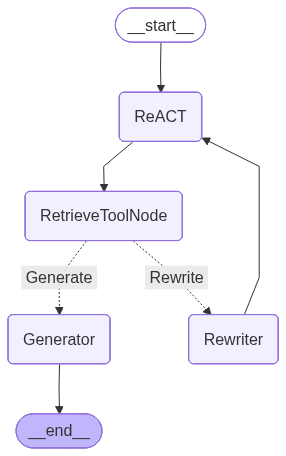

In [183]:

workflow = StateGraph(AgentState)
workflow.add_node('ReACT',reACT_node)
workflow.add_node('RetrieveToolNode',execute_toolnode)
workflow.add_node('Rewriter',rewrite_question)
workflow.add_node('Generator',generate)

workflow.add_edge(START,'ReACT')
workflow.add_edge('ReACT','RetrieveToolNode')
workflow.add_conditional_edges(
    'RetrieveToolNode',
    context_grader,
    {
        "Rewrite":"Rewriter",
        "Generate":"Generator"
    }

)
workflow.add_edge('Rewriter','ReACT')
workflow.set_entry_point('ReACT')

graph = workflow.compile()
graph

In [184]:
graph = workflow.compile().invoke({'messages':[HumanMessage(content='Did India win the t20 series in Australia?')]})
graph

Tool Called :tavily_search
--Generation the Question--


{'messages': [HumanMessage(content='Did India win the t20 series in Australia?', additional_kwargs={}, response_metadata={}, id='eb15d7e0-9d39-4ddd-808f-c64bb0f93c53'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"topic": "news", "query": "India Australia t20 series result"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--aabf4b46-259c-4547-925f-475eb808d74e-0', tool_calls=[{'name': 'tavily_search', 'args': {'topic': 'news', 'query': 'India Australia t20 series result'}, 'id': 'b7324b9a-85c1-4119-9eb2-ddd386dea3ef', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1567, 'output_tokens': 14, 'total_tokens': 1581, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='{\'query\': \'India Australia t20 series result\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'resu